<a href="https://colab.research.google.com/github/RiccardoMPesce/EEG-Classification-AI/blob/main/eeg_signal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
! cp -r /content/drive/MyDrive/EEGSignalClassification/models/ models/
! cp -r /content/drive/MyDrive/EEGSignalClassification/model_checkpoints/ model_checkpoints/
! cp -r /content/drive/MyDrive/EEGSignalClassification/layers.py .

# EEG Signal Classification Notebook

## Walkthrough

The main objective of this task is to obtain a neural representation from the output of both a typical Convulutional Neural Network which feeds on images and from a Convolutional Neural Network which processes and classifies EEG signals, and compare the obtained representations in order to try and find a correlation between the two.

### Setup

Let"s start by importing `torch` (PyTorch).

In [57]:
import torch
import platform

print(f"Platform used: {platform.platform()}")

Platform used: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic


In the original file, we defined the different arguments using the `argparse` library. In this notebook, we devote a whole cell to define all the arguments needed by our analysis.

In [58]:
from pathlib import Path

EEG_DATASET_BASE_PATH = Path("/content/drive/MyDrive/EEGSignalClassification/data")

EEG_DATASET_PATH = EEG_DATASET_BASE_PATH / "eeg_5_95_std.pth"

CHECKPOINT_BASE_PATH = Path("/content/drive/MyDrive/EEGSignalClassification/model_checkpoints/")

JSON_BASE_PATH = Path("/content/drive/MyDrive/EEGSignalClassification/JSON/")

JSON_ACCURACY_FILE_PATH = JSON_BASE_PATH / "accuracy_dict.json"
JSON_LOSS_FILE_PATH = JSON_BASE_PATH / "loss_dict.json"

SPLITS_PATH = EEG_DATASET_BASE_PATH / "block_splits_by_image_all.pth"

# Leave this always to zero
SPLIT_NUM = 0

# Subject selecting
# Choose a subject from 1 to 6, default is 0 (all subjects)
SUBJECT = 0

# Time options: select from 20 to 460 samples from EEG data
TIME_LOW = 20
TIME_HIGH = 460

# Model type/options
# Specify which generator should be used. Available: lstm | EEGChannelNet
# It is possible to test out multiple deep classifiers:
#   - lstm is the model described in the paper 
#     "Deep Learning Human Mind for Automated Visual Classification”, CVPR 2017
#   - model10 is the model described in the paper 
#     "Decoding brain representations by multimodal learning of neural activity and visual features", TPAMI 2020
MODEL_TYPE = "lstm"

MODEL_PARAMS = ""
PRETRAINED_NET = ""

# Training options
BATCH_SIZE = 16
OPTIMIZER = "Adam"
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY_BY = 0.5
LEARNING_RATE_DECAY_EVERY = 10
DATA_WORKERS = 4
EPOCHS = 200

# Save every SAVE_CHECK epochs
SAVE_CHECK = 2

# Backend options
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    print("CUDA available")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    # BATCH_SIZE = 440
    print("MPS (Metal) available")
else:
    DEVICE = torch.device("cpu")
    print("CPU available")

torch.utils.backcompat.broadcast_warning.enabled = True

# Force CPU
# print("Forcing CPU")
# DEVICE = torch.device("cpu")

# Debug Mode
DEBUG = False


CUDA available


Let's define our `EEGDataset` and `Splitter` classes as defined in the file [`eeg_signal_classification.py`](./eeg_signal_classification.py)

In [59]:
class EEGDataset:
    def __init__(self, eeg_signals_path, subject=0, time_low=20, time_high=460, model_type="lstm"):
        self.subject = subject
        self.time_low = time_low
        self.time_high = time_high
        self.model_type = model_type

        # Load EEG signals
        loaded = torch.load(eeg_signals_path)
        if subject != 0:
            self.data = [loaded["dataset"][i] for i in range(
                len(loaded["dataset"])) if loaded["dataset"][i]["subject"] == subject]
        else:
            self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]

        # Compute size
        self.size = len(self.data)

    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = self.data[i]["eeg"].float().t()
        eeg = eeg[self.time_low:self.time_high, :]

        if self.model_type == "model10":
            eeg = eeg.t()
            eeg = eeg.view(1, 128, self.time_high - self.time_low)
        # Get label
        label = self.data[i]["label"]
        
        return eeg, label

class Splitter:
    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        # Set EEG dataset
        self.dataset = dataset
        # Load split
        loaded = torch.load(split_path)
        self.split_idx = loaded["splits"][split_num][split_name]
        # Filter data
        self.split_idx = [i for i in self.split_idx if 450 <=
                          self.dataset.data[i]["eeg"].size(1) <= 600]
        # Compute size
        self.size = len(self.split_idx)

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        # Get sample from dataset
        eeg, label = self.dataset[self.split_idx[i]]
        
        return eeg, label
        

### Sample Dataset and Model initialization

Let's now create the dataset and load the model using the data from the original paper.

In [60]:
from torch.utils.data import DataLoader

dataset = EEGDataset(EEG_DATASET_PATH)
loaders = {
    split: DataLoader(
        Splitter(dataset, split_path=SPLITS_PATH, split_num=SPLIT_NUM, split_name=split),
        batch_size=BATCH_SIZE, drop_last=True, shuffle=True
    ) for split in ["train", "val", "test"]
}

Now let's load the model, move to the appropriate device and let's create the optimizer.

In [61]:
import importlib

# Load model
model_options = {
    key: int(value) if value.isdigit() else (
        float(value) if value[0].isdigit() else value
    ) for (key, value) in [x.split("=") for x in MODEL_PARAMS]
}

# Create discriminator model/optimizer
module = importlib.import_module("models." + MODEL_TYPE)
model = module.Model(**model_options)
# Moving model to the appropriate device
model.to(DEVICE)
print(f"Model has been moved to device '{DEVICE}'")
# Creating the optimizer
optimizer = getattr(torch.optim, OPTIMIZER)(model.parameters(), lr=LEARNING_RATE)


Model has been moved to device 'cuda'


Let's load a pretrained model if we specified a path.

In [62]:
if PRETRAINED_NET != "":
    print(f"Loading a pretrained model from '{PRETRAINED_NET}'")
    model = torch.load(PRETRAINED_NET)
    model.to(DEVICE)
    
print(f"Model: {model}")

Model: Model(
  (lstm): LSTM(128, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=40, bias=True)
)


### Training, Validation and Test options setup

Let's now set up the training/validation/test options.

In [63]:
import json

# Initialize training, validation, test losses and accuracy list

if JSON_ACCURACY_FILE_PATH.exists() and JSON_ACCURACY_FILE_PATH.is_file():
    with open(JSON_ACCURACY_FILE_PATH, "r+") as accuracy_json_f:
        accuracies_per_epoch = json.load(accuracy_json_f)
else:
    accuracies_per_epoch = {"train": [], "val": [], "test": []}

if JSON_LOSS_FILE_PATH.exists() and JSON_LOSS_FILE_PATH.is_file():
    with open(JSON_LOSS_FILE_PATH, "r+") as loss_json_f:
        losses_per_epoch = json.load(loss_json_f)
else:
    losses_per_epoch = {"train": [], "val": [], "test": []}

best_accuracy = 0
best_accuracy_val = 0
best_epoch = 0

### Training loop

Now we can finally run the training loop.

In [69]:
import torch.nn.functional as F

import shutil
import re

starting_epoch = 0

# Check for the latest weights
checkpoints = [checkpoint for checkpoint in CHECKPOINT_BASE_PATH.glob("*.pth")]

if len(checkpoints) > 0:
    epochs = [
        int(re.search("(\d+).pth", str(s)).group().replace(".pth", "")) for s in checkpoints
    ]

    latest_state_dict_path = CHECKPOINT_BASE_PATH / f"{MODEL_TYPE}__subject{SUBJECT}_epoch_{max(epochs)}.pth"

    # Loading state dict
    model.load_state_dict(torch.load(latest_state_dict_path))

    starting_epoch = max(epochs)

# Start training
predicted_labels = [] 
correct_labels = []

for epoch in range(starting_epoch + 1, EPOCHS + starting_epoch + 1):
    # Initialize loss/accuracy variables
    losses = {"train": 0, "val": 0, "test": 0}
    accuracies = {"train": 0, "val": 0, "test": 0}
    counts = {"train": 0, "val": 0, "test": 0}
    
    # Adjust learning rate for SGD
    if OPTIMIZER == "SGD":
        lr = LEARNING_RATE * (LEARNING_RATE_DECAY_BY ** (epoch // LEARNING_RATE_DECAY_EVERY))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    
    # Process each split
    for split in ("train", "val", "test"):
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        
        # Process all split batches
        for i, (input, target) in enumerate(loaders[split]):
            
            # Move tensors to device
            input = input.to(DEVICE)
            target = target.to(DEVICE)
            
            if DEBUG:
                print(input.device)

            # Forward
            output = model(input)

            # Compute loss
            loss = F.cross_entropy(output, target)
            losses[split] += loss.item()
            
            # Compute accuracy
            _, pred = output.data.max(1)
            correct = pred.eq(target.data).sum().item()
            accuracy = correct / input.data.size(0)   
            accuracies[split] += accuracy
            counts[split] += 1
            
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    # Print info at the end of the epoch
    if accuracies["val"] / counts["val"] >= best_accuracy_val:
        best_accuracy_val = accuracies["val"] / counts["val"]
        best_accuracy = accuracies["test"] / counts["test"]
        best_epoch = epoch

    train_loss = losses["train"] / counts["train"]
    train_accuracy = accuracies["train"] / counts["train"]
    validation_loss = losses["val"] / counts["val"]
    validation_accuracy = accuracies["val"] / counts["val"]
    test_loss = losses["test"] / counts["test"]
    test_accuracy = accuracies["test"] / counts["test"]

    print("INFO")
    print(f"- Model: {MODEL_TYPE} - Subject: {SUBJECT} - Time interval: [{TIME_LOW}-{TIME_HIGH}] [{TIME_LOW}-{TIME_HIGH} Hz] - Epoch: {epoch}")
    print("STATS")
    print(f"- Training: Loss {train_loss:.4f}, Accuracy {train_accuracy:.4f} " 
          f"- Validation: Loss {validation_loss:.4f}, Accuracy {validation_accuracy:.4f} "
          f"- Test: Loss {test_loss:.4f}, Accuracy {test_accuracy:.4f}")
    print(f"Best Test Accuracy at maximum Validation Accuracy (validation_accuracy = {best_accuracy_val:.4f}) is {best_accuracy:.4f} at epoch {best_epoch}\n")

    losses_per_epoch["train"].append(train_loss)
    losses_per_epoch["val"].append(validation_loss)
    losses_per_epoch["test"].append(test_loss)
    accuracies_per_epoch["train"].append(train_accuracy)
    accuracies_per_epoch["val"].append(validation_accuracy)
    accuracies_per_epoch["test"].append(test_accuracy)

    if epoch % SAVE_CHECK == 0:
        torch.save(model.state_dict(), CHECKPOINT_BASE_PATH / f"{MODEL_TYPE}__subject{SUBJECT}_epoch_{epoch}.pth")
        
        with open(JSON_ACCURACY_FILE_PATH, "w+") as accuracy_json_f:
            json.dump(accuracies_per_epoch, accuracy_json_f)
        
        with open(JSON_LOSS_FILE_PATH, "w+") as loss_json_f:
            json.dump(losses_per_epoch, loss_json_f)

# At the end of training, save
torch.save(model.state_dict(), CHECKPOINT_BASE_PATH / f"{MODEL_TYPE}__subject{SUBJECT}_epoch_{epoch}.pth")
        
with open(JSON_ACCURACY_FILE_PATH, "w+") as accuracy_json_f:
    json.dump(accuracies_per_epoch, accuracy_json_f)

with open(JSON_LOSS_FILE_PATH, "w+") as loss_json_f:
    json.dump(losses_per_epoch, loss_json_f)



INFO
- Model: lstm - Subject: 0 - Time interval: [20-460] [20-460 Hz] - Epoch: 201
STATS
- Training: Loss 0.1870, Accuracy 0.9673 - Validation: Loss 5.4132, Accuracy 0.2092 - Test: Loss 5.6276, Accuracy 0.2016
Best Test Accuracy at maximum Validation Accuracy (validation_accuracy = 0.2273) is 0.2036 at epoch 97

INFO
- Model: lstm - Subject: 0 - Time interval: [20-460] [20-460 Hz] - Epoch: 202
STATS
- Training: Loss 0.4011, Accuracy 0.8981 - Validation: Loss 5.5699, Accuracy 0.1986 - Test: Loss 5.6917, Accuracy 0.1930
Best Test Accuracy at maximum Validation Accuracy (validation_accuracy = 0.2273) is 0.2036 at epoch 97

INFO
- Model: lstm - Subject: 0 - Time interval: [20-460] [20-460 Hz] - Epoch: 203
STATS
- Training: Loss 0.3416, Accuracy 0.9105 - Validation: Loss 5.4605, Accuracy 0.1946 - Test: Loss 5.6258, Accuracy 0.1956
Best Test Accuracy at maximum Validation Accuracy (validation_accuracy = 0.2273) is 0.2036 at epoch 97

INFO
- Model: lstm - Subject: 0 - Time interval: [20-460] 

We can print the model statistics so as we get an idea on how our model performed.

In [70]:
import matplotlib.pyplot as plt
import pandas as pd 

accuracy_df = pd.DataFrame(accuracies_per_epoch)
loss_df = pd.DataFrame(losses_per_epoch)


Let's see the accuracy first.

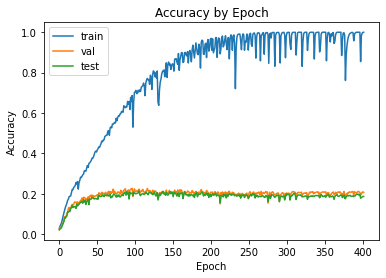

In [71]:
accuracy_df.plot(title="Accuracy by Epoch", xlabel="Epoch", ylabel="Accuracy")
plt.show()

And now, let's see the loss.

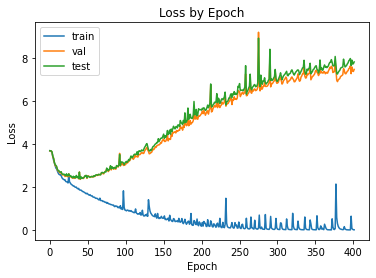

In [72]:
loss_df.plot(title="Loss by Epoch", xlabel="Epoch", ylabel="Loss")
plt.show()

It's easy to see that we are overfitting the model given that we are only achieving good performances on the training set, but for validation and test sets we are performing poorly. This can be due to one or more of the following reasons:

*   The hyperparameters (such as the _learning rate_) are not set properly, thus we need to go through a process of __hyperparameter tuning__.
*   The model used (a simple `LSTM`) is not enough for this purpose, and we need more sophisticated/different models.

